In [1]:
import os
from os.path import basename, dirname, join, exists
import glob 

import pandas as pd
import numpy as np

import geopandas as gpd


In [2]:
doc_dir = os.getcwd()
while basename(doc_dir) != 'Documents':
    doc_dir = dirname(doc_dir)
# dir of all gwfm data
gwfm_dir = dirname(doc_dir)+'/Box/research_cosumnes/GWFlowModel'

sfr_dir = gwfm_dir+'/SFR_data/'
uzf_dir = gwfm_dir+'/UZF_data/'

In [3]:
# New model domain 52.9 deg
m_domain = gpd.read_file(gwfm_dir+'/DIS_data/NewModelDomain/GWModelDomain_52_9deg_UTM10N_WGS84.shp')

# Load model grid as geopandas object
grid_p = gpd.read_file(gwfm_dir+'/DIS_data/grid/grid.shp')


In [4]:
# load other model parameters
ucode_dir = join(gwfm_dir, 'UCODE')
# bc_params = param_load(model_ws, ucode_dir, 'BC_scaling.csv')
bc_params = pd.read_csv(join(ucode_dir,'BC_scaling.csv'))
bc_params = bc_params.set_index('ParamName')

In [5]:
nrow,ncol = (100,230)
delr, delc = (200, 200)

In [6]:
uzf_dir = join(gwfm_dir, 'UZF_data')
gde_dir = join(uzf_dir,'shp_GDE_TFT')

glob.glob(join(gde_dir,'SA_subbasin_GDE','*shp'))

if not exists(join(gde_dir,'gde_domain.shp')):
    # large file
    GDE_union = gpd.read_file(join(gde_dir,'SA_subbasin_GDE','GDE_union.shp'))
    # GDE_union = gpd.read_file(join(gde_dir,'SA_subbasin_GDE','NCAG_vegetation.shp'))
    # is it worth differentiating mixed riparian scrub, woodland, forest? for et rates and rooting depths
    GDE_domain = gpd.overlay(GDE_union, m_domain.to_crs(GDE_union.crs))
    # simplify columns 
    GDE_domain = GDE_domain[['Type','Source','geometry']]
    # save file
    GDE_domain.to_file(join(gde_dir, 'gde_domain.shp'))
else:
    GDE_domain = gpd.read_file(join(gde_dir, 'gde_domain.shp'))


In [7]:
GDE_domain.to_file(join(gde_dir, 'gde_domain.shp'))


In [8]:
lu_native = gpd.read_file(join(uzf_dir, 'county_landuse', 'domain_native_lu_2018.shp'))
lu_native = gpd.overlay(lu_native, m_domain)
# simplify columns
lu_native = lu_native[['name','geometry']]

In [9]:
# subset rooting depth parameters
rtg_params = bc_params[bc_params.GroupName=='EVT_rtg_dp']


In [10]:
# join polygon to grid and keep cells with more than 0.5 in grid
nat_grid = gpd.overlay(lu_native.to_crs(grid_p.crs), grid_p)
nat_grid = nat_grid[nat_grid.geometry.area > delr*delc*0.5]
# default rooting depth as 4m for native vegetation
nat_grid['rtg_dp'] = rtg_params.loc['native', 'StartValue']
# riparian vegation gets deeper roots
nat_grid.loc[nat_grid.name=='Native riparian vegetation', 'rtg_dp'] = rtg_params.loc['native_rip', 'StartValue']
nat_grid = nat_grid.drop(columns=['name'])

<Axes: >

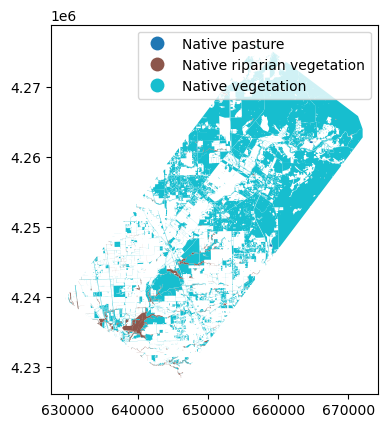

In [11]:
lu_native.plot('name', legend=True)

<Axes: >

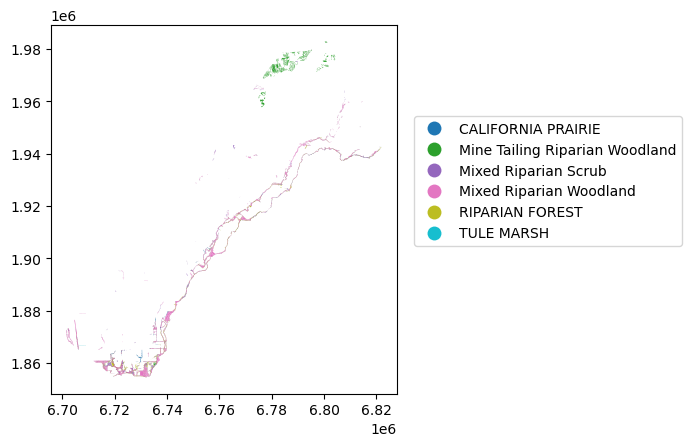

In [12]:
# the visual map combined with field knowledge suggests that it is mapping the location of higher tree density
# that occur along the river channel and near certains roads/drainages
# it's worth identifying these as zones up to 30 ft (9 m) while leaving the rest up to 6 ft (2 m) which is max depth for 
# more field type crops
GDE_domain.plot('Type',legend=True, legend_kwds={'loc':(1.05,0.4)})

In [13]:
if not exists(join(gde_dir,'GDE_cell.shp')):
    # spatial join with grid to identify cells with deeper rooting depth
    # GDE_domain has polygons with Z dimension which takes more space
    GDE_grid = gpd.sjoin(grid_p, GDE_domain.to_crs(grid_p.crs), how='inner', predicate='intersects')
#     GDE_grid = gpd.sjoin(GDE_domain.to_crs(grid_p.crs), grid_p, how='inner', predicate='intersects')

    GDE_grid['rtg_dp'] = rtg_params.loc['native', 'StartValue'] # default rooting depth to 2 meters
    # scrub could be an intermediate??
    GDE_grid.loc[GDE_grid.Type=='Mixed Riparian Scrub','rtg_dp'] = rtg_params.loc['native_rip', 'StartValue']
    # those described as woodland/forest get deeper designation
    GDE_grid.loc[GDE_grid.Type=='Mixed Riparian Woodland','rtg_dp'] = rtg_params.loc['rip_woodland', 'StartValue']
    GDE_grid.loc[GDE_grid.Type=='RIPARIAN FOREST','rtg_dp'] = rtg_params.loc['rip_forest', 'StartValue']

    # slow to compute
    GDE_cell = GDE_grid.dissolve(by='node', aggfunc = 'mean', numeric_only=True)
    GDE_cell.to_file(join(gde_dir,'GDE_cell.shp'))
else:
    GDE_cell = gpd.read_file(join(gde_dir,'GDE_cell.shp'))

In [14]:
# joining the native land use map to this really helps fill it in 
# because GDE analysis was only for the SASb
GDE_all = pd.concat((GDE_cell, nat_grid)).dissolve(['row','column'], aggfunc='mean').reset_index()
GDE_all.to_file(join(gde_dir,'GDE_and_native_cell.shp'))

<Axes: >

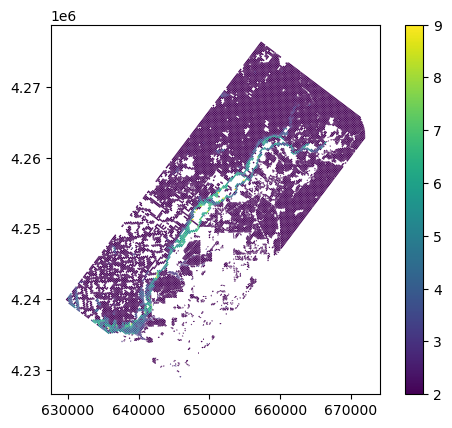

In [15]:

GDE_all.plot('rtg_dp', legend=True)

In [16]:
# convert rooting depth to array format for modflow input
# ext_dp = np.full((nrow,ncol),2)
# ext_dp[(GDE_cell.row-1).astype(int), (GDE_cell.column-1).astype(int)] = GDE_cell.rtg_dp

# convert rooting depth to array format for modflow input, hydrographs in wells show drawdown to about 10 m
# below ground so should use 10 m for all gde
ext_dp = np.full((nrow,ncol),2)
# ext_dp[(GDE_cell.row-1).astype(int), (GDE_cell.column-1).astype(int)] = 10
# ext_dp[(GDE_all.row-1).astype(int), (GDE_all.column-1).astype(int)] = 10
ext_dp[(GDE_all.row-1).astype(int), (GDE_all.column-1).astype(int)] = GDE_all.rtg_dp